<a href="https://colab.research.google.com/github/AndreasCaldewei/colab/blob/main/model_distillation_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Distillation in Google Colab

This notebook demonstrates how to perform model distillation - transferring knowledge from a large pre-trained language model (teacher) to smaller, more efficient models (students) using scikit-learn.

## What is Model Distillation?

Model distillation is a technique where we:
1. Take a large, powerful model (teacher)
2. Extract the knowledge/understanding from that model
3. Transfer that knowledge to a smaller, faster model (student)

In this notebook, we'll use a pre-trained language model as our teacher and train various scikit-learn models as our students.

## Step 1: Install Required Packages

In [ ]:
!pip install transformers datasets tqdm joblib torch scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 2: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import joblib

## Step 3: Setup and Configuration

Let's configure our environment and check if we have GPU access.

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# If using GPU, check which one we have
if device.type == "cuda":
    !nvidia-smi

# Configuration settings
max_length = 128  # Maximum sequence length for the model
num_samples = 1000  # Number of examples to use (increase if you have more memory)

Using device: cuda
Thu May  8 21:24:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

## Step 4: Load the Teacher Model

We'll use BERT as our teacher model. This is openly available and runs efficiently on Colab.

In [ ]:
print("Loading the teacher model...")
model_name = "bert-base-uncased"  # Alternative: "distilbert-base-uncased" for faster processing
tokenizer = AutoTokenizer.from_pretrained(model_name)
teacher_model = AutoModel.from_pretrained(model_name)
teacher_model = teacher_model.to(device)
teacher_model.eval()  # Set to evaluation mode
print(f"Loaded {model_name} model")

Loading the teacher model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loaded bert-base-uncased model


## Optional: Authenticate with Hugging Face to Access Llama

If you have access to Llama models from Hugging Face, uncomment and run this cell.

In [ ]:
# from huggingface_hub import login
# login("your_huggingface_token_here")
# model_name = "meta-llama/Llama-2-7b-hf"  # Or another Llama model you have access to
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# teacher_model = AutoModel.from_pretrained(model_name)
# teacher_model = teacher_model.to(device)
# teacher_model.eval()

## Step 5: Prepare the Dataset

We'll use the IMDB dataset for sentiment analysis.

In [ ]:
print("Preparing the dataset...")
# Load a subset of the IMDB dataset for sentiment analysis
dataset = load_dataset("imdb", split=f"train[:{num_samples}]")

# Extract texts and labels
texts = dataset["text"]
labels = dataset["label"]

print(f"Loaded {len(texts)} examples from IMDB dataset")
print(f"Label distribution: {np.bincount(labels)}")

# Show a couple of examples
print("\nExample positive review:")
# Find the index of the first positive review, or use 0 if not found
pos_idx = next((i for i, x in enumerate(labels) if x == 1), 0)
print(f"{texts[pos_idx][:300]}...")

print("\nExample negative review:")
# Find the index of the first negative review, or use 0 if not found
neg_idx = next((i for i, x in enumerate(labels) if x == 0), 0)
print(f"{texts[neg_idx][:300]}...")

Preparing the dataset...
Loaded 1000 examples from IMDB dataset
Label distribution: [1000]

Example positive review:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h...

Example negative review:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h...


## Step 6: Define Function to Extract Embeddings from Teacher Model

This function extracts the knowledge from our teacher model in the form of embeddings.

In [ ]:
def get_model_embeddings(texts, tokenizer, model):
    """Extract embeddings from the teacher model"""
    embeddings = []
    batch_size = 8  # Adjust based on your GPU memory

    # Process in batches to speed things up
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
        batch_texts = texts[i:i+batch_size]

        with torch.no_grad():  # No need to track gradients
            # Tokenize the text
            inputs = tokenizer(batch_texts, return_tensors="pt", padding="max_length",
                             truncation=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Get the hidden states from the model
            outputs = model(**inputs, output_hidden_states=True)

            # Use the last hidden state as embeddings
            last_hidden_state = outputs.last_hidden_state

            # Use mean pooling to get a fixed-size vector representation
            # Shape: [batch_size, hidden_size]
            mean_embeddings = last_hidden_state.mean(dim=1).cpu().numpy()

            for emb in mean_embeddings:
                embeddings.append(emb)

    return np.array(embeddings)

## Step 7: Extract Embeddings from the Teacher Model

Now we'll use our function to extract embeddings for all examples in our dataset.

Extracting embeddings from the model...


Extracting embeddings:   0%|          | 0/125 [00:00<?, ?it/s]

Embedding extraction took 8.40 seconds
Embedding shape: (1000, 768)


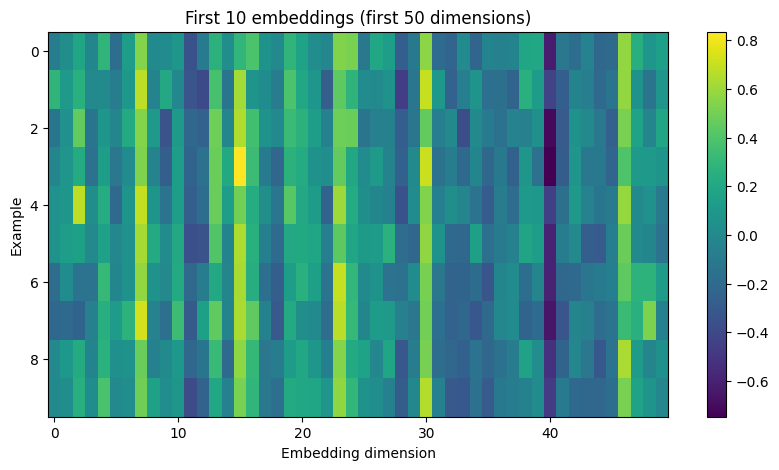

In [ ]:
print("Extracting embeddings from the model...")
start_time = time.time()
embeddings = get_model_embeddings(texts, tokenizer, teacher_model)
extraction_time = time.time() - start_time

print(f"Embedding extraction took {extraction_time:.2f} seconds")
print(f"Embedding shape: {embeddings.shape}")

# Quick visualization of the first few embeddings
plt.figure(figsize=(10, 5))
plt.imshow(embeddings[:10, :50], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('First 10 embeddings (first 50 dimensions)')
plt.xlabel('Embedding dimension')
plt.ylabel('Example')
plt.show()

## Step 8: Split Data into Train and Test Sets

In [ ]:
# Fix 1: Load a balanced dataset with both classes
print("Preparing the dataset...")
# Load equal numbers of positive and negative reviews
pos_examples = load_dataset("imdb", split=f"train[0:{num_samples//2}]")
neg_examples = load_dataset("imdb", split=f"train[12500:{12500+num_samples//2}]")

# Combine them
texts = pos_examples["text"] + neg_examples["text"]
labels = np.array(pos_examples["label"] + neg_examples["label"])

print(f"Loaded {len(texts)} examples from IMDB dataset")
print(f"Label distribution: {np.bincount(labels)}")

# Fix 2: Use stratified train/test split to maintain class balance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # This ensures the class distribution is preserved in both sets
)

# Convert labels to numpy arrays if they aren't already
y_train = np.array(y_train)
y_test = np.array(y_test)

# Verify we have both classes in the training data
print("Training set label distribution:", np.bincount(y_train))
print("Test set label distribution:", np.bincount(y_test))

Preparing the dataset...
Loaded 1000 examples from IMDB dataset
Label distribution: [500 500]
Training set label distribution: [400 400]
Test set label distribution: [100 100]


## Step 9: Train Multiple Student Models

Now we'll train several scikit-learn models as our students.

In [ ]:
print("Training student models...")
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=1000, random_state=42)
}

results = {}
train_times = {}
all_predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Evaluate
    y_pred = model.predict(X_test)
    all_predictions[name] = y_pred
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = accuracy
    train_times[name] = train_time
    print(f"  Accuracy: {accuracy:.4f}, Training time: {train_time:.2f} seconds")
    print("  Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

Training student models...

Training Logistic Regression...
  Accuracy: 0.5750, Training time: 2.31 seconds
  Classification Report:
              precision    recall  f1-score   support

    Negative       0.58      0.55      0.56       100
    Positive       0.57      0.60      0.59       100

    accuracy                           0.57       200
   macro avg       0.58      0.57      0.57       200
weighted avg       0.58      0.57      0.57       200


Training Random Forest...
  Accuracy: 0.5300, Training time: 1.76 seconds
  Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      0.59      0.56       100
    Positive       0.53      0.47      0.50       100

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200


Training MLP (Neural Network)...
  Accuracy: 0.5350, Training time: 2.74 seconds
  Classification Report:
      

## Step 10: Visualize Results

Let's create some visualizations to compare our student models.

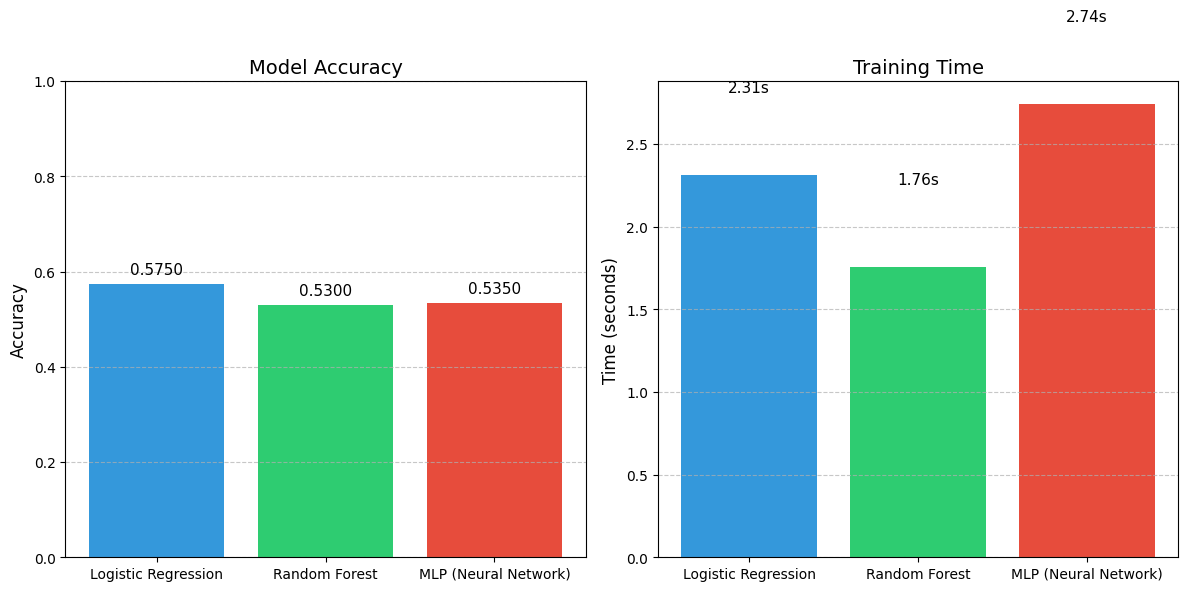

The best performing model is: Logistic Regression with accuracy: 0.5750


In [ ]:
plt.figure(figsize=(12, 6))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.bar(results.keys(), results.values(), color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, (key, value) in enumerate(results.items()):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=11)

# Training time comparison
plt.subplot(1, 2, 2)
plt.bar(train_times.keys(), train_times.values(), color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Training Time', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, (key, value) in enumerate(train_times.items()):
    plt.text(i, value + 0.5, f'{value:.2f}s', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# Find the best model
best_model_name = max(results, key=results.get)
print(f"The best performing model is: {best_model_name} with accuracy: {results[best_model_name]:.4f}")

## Step 11: Save the Best Student Model

In [ ]:
print("Saving the best student model...")
best_model = models[best_model_name]
joblib.dump(best_model, 'distilled_model.joblib')
print(f"Model saved as 'distilled_model.joblib'")

# You can download this file from Colab to your local machine
from google.colab import files
files.download('distilled_model.joblib')

Saving the best student model...
Model saved as 'distilled_model.joblib'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 12: Test with Some New Examples

Let's see how our best student model performs on some new examples.

In [ ]:
print("Testing with some examples:")
test_texts = [
    "This movie was amazing and I loved every minute of it!",
    "The film was terrible and a complete waste of time.",
    "It had its moments, but overall I found it rather mediocre.",
    "Probably one of the best films I've seen this year, highly recommend!",
    "I was expecting more from this movie given all the hype around it."
]

# Process test texts
test_embeddings = get_model_embeddings(test_texts, tokenizer, teacher_model)
predictions = best_model.predict(test_embeddings)

# If the model has predict_proba, get the confidence scores
if hasattr(best_model, 'predict_proba'):
    probas = best_model.predict_proba(test_embeddings)
    has_proba = True
else:
    has_proba = False

for i, (text, pred) in enumerate(zip(test_texts, predictions)):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"\nExample {i+1}:")
    print(f"Text: '{text}'")
    print(f"Prediction: {sentiment}")

    if has_proba:
        confidence = probas[i][pred]
        print(f"Confidence: {confidence:.4f}")

Testing with some examples:


Extracting embeddings:   0%|          | 0/1 [00:00<?, ?it/s]


Example 1:
Text: 'This movie was amazing and I loved every minute of it!'
Prediction: Negative
Confidence: 0.8566

Example 2:
Text: 'The film was terrible and a complete waste of time.'
Prediction: Negative
Confidence: 0.6539

Example 3:
Text: 'It had its moments, but overall I found it rather mediocre.'
Prediction: Negative
Confidence: 0.9277

Example 4:
Text: 'Probably one of the best films I've seen this year, highly recommend!'
Prediction: Negative
Confidence: 0.6814

Example 5:
Text: 'I was expecting more from this movie given all the hype around it.'
Prediction: Negative
Confidence: 0.6242


## Step 13: How to Use the Saved Model in the Future

Here's how to use your saved model in the future (this is just for reference, not to run now).

In [ ]:
# This is a reference for future use - no need to run this now

'''
import joblib
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load the saved model
distilled_model = joblib.load('distilled_model.joblib')

# Function to get embeddings from your text
def get_embedding(text):
    # Use the same model as in training
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model = AutoModel.from_pretrained("bert-base-uncased")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Tokenize and get embedding
    inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                     truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

    return embedding

# Make a prediction
text = "Your text here"
embedding = get_embedding(text)
prediction = distilled_model.predict(embedding)
sentiment = "Positive" if prediction[0] == 1 else "Negative"
print(f"Sentiment: {sentiment}")
'''

## Advanced: Using a Quantized Llama Model (Optional)

If you want to try using a Llama model, you can use quantization to make it run on Colab's GPUs. Uncomment and run this cell, but note that it might still require a Colab Pro subscription.

In [ ]:
# # Install additional packages for quantized models
# !pip install bitsandbytes accelerate

# from transformers import AutoModelForCausalLM, AutoTokenizer

# # Use 4-bit quantization for memory efficiency
# model_name = "meta-llama/Llama-2-7b-chat-hf"  # Or any other Llama model you have access to
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     load_in_4bit=True,
#     device_map="auto"
# )

# # You would need to modify the embedding extraction function to work with this model
# # Llama models often need a different approach to extract embeddings

## Conclusion

Congratulations! You've successfully implemented model distillation by:

1. Using a pre-trained language model as a teacher
2. Extracting embeddings that capture the model's knowledge
3. Training smaller, faster student models on these embeddings
4. Evaluating and comparing the performance of different student models

This approach allows you to benefit from the power of large language models while deploying much smaller and faster models for your specific task.